# Accelerating training of a DNN using SVD - MNIST Example

In this example, we test SVD-DNN on the MNIST digit classification dataset (see the paper for more details).

We also compare the affect of changing some hyperparameters in the SVD-DNN model.

In [64]:
using MLDatasets # used to import the MNIST dataset
using LaTeXStrings # used to draw symbols in plots

using LinearAlgebra

using Flux
using Flux: onehotbatch, onecold, @epochs
using Flux.Data: DataLoader
using Flux.Optimise
using Zygote: Params

using TimerOutputs

using Plots

In [5]:
include("../SVDNN.jl")
include("../SVDNN_utils.jl")

train_epochs_svd! (generic function with 3 methods)

In [22]:
reset_timer!(to)

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      198μs / 0.00%           2.67KiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

## Load data

In [6]:
batchsize = 2048
η = 3e-4
# epochs = 10

0.0003

In [7]:
imgsize = (28,28,1)
nclasses=10

10

In [10]:
# Loading Dataset
xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
xtest, ytest = MLDatasets.MNIST.testdata(Float32)

# Reshape Data for flatten the each image into linear array
xtrain = Flux.flatten(xtrain)
xtest = Flux.flatten(xtest)

# One-hot-encode the labels
ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

# Batching
train_data = DataLoader(xtrain, ytrain, batchsize=batchsize, shuffle=true)
test_data = DataLoader(xtest, ytest, batchsize=batchsize)

DataLoader((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 2048, 10000, true, 10000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000], false)

In [11]:
size(xtrain)

(784, 60000)

## Build Model

In [70]:
model = Chain(
    Dense(prod(imgsize), 512, relu),
    Dense(512, 256, relu),
    Dense(256, nclasses))

opt = ADAM(η)
opt2 = ADAM(η)
# opt = Descent(η)

loss(x, y, model) = Flux.logitcrossentropy(model(x), y)

costs = []
accuracies = []
test_accuracies = []

0-element Array{Any,1}

In [13]:
function cost_function(dataloader, loss, model)
    l = 0f0
    for (x, y) in dataloader
        l += loss(x, y, model)
    end
    l/length(dataloader)
end

cost_function (generic function with 1 method)

In [14]:
function accuracy(data_loader, model)
    acc = 0
    for (x,y) in data_loader
        acc += sum(onecold(cpu(model(x))) .== onecold(cpu(y)))*1 / size(x,2)
    end
    acc/length(data_loader)
end

accuracy (generic function with 1 method)

## Train normally

In [24]:
@timeit to "Full training" train_epochs!(loss, train_data, test_data, opt, model, 10)

Cost at epoch 1 is 0.51514375. Accuracy 0.871325897752193. Test accuracy 0.8804912195796459
Cost at epoch 2 is 0.30374622. Accuracy 0.9165981359649124. Test accuracy 0.9193419870022124
Cost at epoch 3 is 0.24540286. Accuracy 0.9318205180921052. Test accuracy 0.9347967367256637
Cost at epoch 4 is 0.20819518. Accuracy 0.9419330797697368. Test accuracy 0.9437283946349557
Cost at epoch 5 is 0.18088348. Accuracy 0.9494346217105264. Test accuracy 0.9466840085730089
Cost at epoch 6 is 0.16012439. Accuracy 0.9563887746710527. Test accuracy 0.9547367602323009
Cost at epoch 7 is 0.1428251. Accuracy 0.9603601288377193. Test accuracy 0.9571193998893806
Cost at epoch 8 is 0.12751986. Accuracy 0.9650090803179824. Test accuracy 0.9606021847345133
Cost at epoch 9 is 0.11475808. Accuracy 0.9686000890899124. Test accuracy 0.9629519842367257
Cost at epoch 10 is 0.10470912. Accuracy 0.9716017338267543. Test accuracy 0.9659075981747787


In [25]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            71.5s / 75.6%           25.8GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training              1    54.1s   100%   54.1s   25.8GiB  100%   25.8GiB
   Train one step          10    31.7s  58.6%   3.17s   14.2GiB  55.1%  1.42GiB
     Calculate grad...    300    23.2s  42.8%  77.2ms   11.2GiB  43.6%  38.4MiB
     Update params        300    6.53s  12.1%  21.8ms   1.20GiB  4.65%  4.10MiB
     Get params            10    903μs  0.00%  90.3μs   13.0KiB  0.00%  1.30KiB
   Calculate accuracy      10    10.8s  20.0%   1.08s   5.38GiB  20.8%   551MiB
   Calculate cost          10    9.61s 

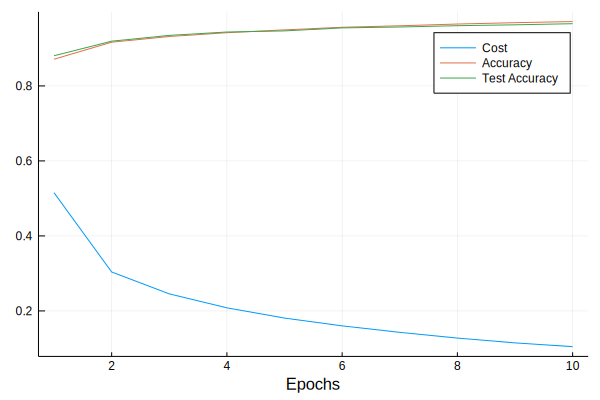

In [26]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")
# vline!([10], label = "SVD start", legend = :right)

## Train using SVDNN

Initialize the model again before executing

In [27]:
function show_maximum_l_values(model)
    maximum_l_values = Integer[]
    for layer in model
        m, n = size(layer.W)
        push!(maximum_l_values, floor((m*n)/(m+n)))
    end
    return maximum_l_values
end

show_maximum_l_values (generic function with 1 method)

In [28]:
max_l_values = show_maximum_l_values(model)

3-element Array{Integer,1}:
 309
 170
   9

Here a new hyperparameter α is introduced. α indicates how many of the singular values are considered in the SVD model. An α of 1/2 means that half of the (best) singular values will be kept for each layer.

Note that the last layer is not converted to a SVDense layer.

In [32]:
# set these values to be lesser than the above
# nothing implies that the layer is not converted to SVDense
α = 1/2
l_values = map(x -> round(Int, x*α), max_l_values)
l_values = Array{Union{Nothing, Integer}}(l_values)
l_values[end] = nothing # no SVD on the last layer, this gives much better results
l_values

3-element Array{Union{Nothing, Integer},1}:
 154       
  85       
    nothing

In [43]:
@timeit to "Full training SVD" train_epochs_svd!(model, l_values, loss, train_data, test_data, opt, opt2, 10)

Cost at epoch 1 is 0.5057886. Accuracy 0.8708675986842105. Test accuracy 0.8776393113938052
Finished pre-training
Built SVD model
SVD Model: Accuracy 0.8469649465460526. Test accuracy 0.8510932314712389
Begin tuning SVD model
Cost at epoch 1 is 0.33082396. Accuracy 0.905114103618421. Test accuracy 0.9092445035951326
Cost at epoch 2 is 0.2620641. Accuracy 0.9243669476425438. Test accuracy 0.9271216468473451
Cost at epoch 3 is 0.21991247. Accuracy 0.937622498629386. Test accuracy 0.938611379977876
Cost at epoch 4 is 0.18681164. Accuracy 0.9465914542214912. Test accuracy 0.9447369330752213
Cost at epoch 5 is 0.16528034. Accuracy 0.9521133155153509. Test accuracy 0.9503163025442477
Cost at epoch 6 is 0.14459608. Accuracy 0.9574929756030702. Test accuracy 0.9548733061393806
Cost at epoch 7 is 0.12845652. Accuracy 0.9629685786732457. Test accuracy 0.959664511891593
Cost at epoch 8 is 0.118258566. Accuracy 0.9663231565241228. Test accuracy 0.961936532079646
Cost at epoch 9 is 0.10597903. Accu

In [44]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             432s / 29.8%           67.1GiB / 96.9%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training SVD          3    74.8s  58.0%   24.9s   39.2GiB  60.3%  13.1GiB
   Tuning SVD model         2    45.6s  35.4%   22.8s   27.4GiB  42.2%  13.7GiB
     [SVD] Train on...     11    26.4s  20.5%   2.40s   14.7GiB  22.6%  1.34GiB
       Calculate gr...    305    20.7s  16.0%  67.8ms   12.3GiB  18.9%  41.3MiB
       Update params      304    3.48s  2.70%  11.4ms    626MiB  0.94%  2.06MiB
       Get params          11   29.3ms  0.02%  2.67ms   1.49MiB  0.00%   139KiB
     [SVD] Calculat...     10    9.37s 

Note the time difference in the previous cell's output. One epoch of SVD-DNN took 2.4s while the normal DNN took 3.17s which is a good improvement. (the time difference could be due to various reasons, but the SVD-DNN consistently gives better times than the normal model)

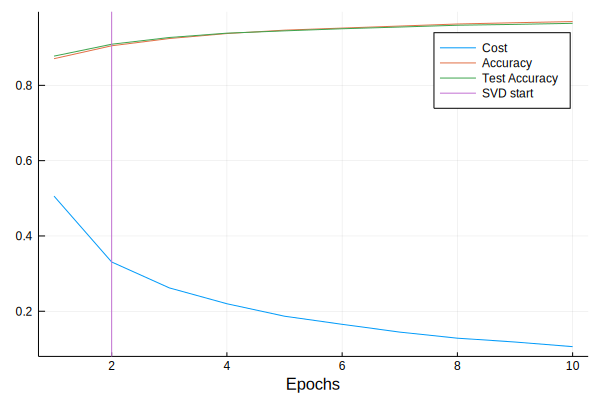

In [45]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")
vline!([2], label = "SVD start", legend = :best)

In [46]:
costs_half = copy(costs)

10-element Array{Any,1}:
 0.5057886f0  
 0.33082396f0 
 0.2620641f0  
 0.21991247f0 
 0.18681164f0 
 0.16528034f0 
 0.14459608f0 
 0.12845652f0 
 0.118258566f0
 0.10597903f0 

## SVD 1/4

In [48]:
# nothing implies that the layer is not converted to SVDense
l_values = map(x -> x ÷ 4, max_l_values)
l_values = Array{Union{Nothing, Integer}}(l_values)
l_values[end] = nothing # no SVD on the last layer, this gives much better results
l_values

3-element Array{Union{Nothing, Integer},1}:
 77       
 42       
   nothing

In [50]:
# re-initialise the model before running
@timeit to "Full training SVD 1/4" train_epochs_svd!(model, l_values, loss, train_data, test_data, opt, opt2, 10)

Cost at epoch 1 is 0.51119405. Accuracy 0.8705677768640351. Test accuracy 0.8783687085176991
Finished pre-training
Built SVD model
SVD Model: Accuracy 0.6655179207785088. Test accuracy 0.6703245990044249
Begin tuning SVD model
Cost at epoch 1 is 0.47031185. Accuracy 0.8690146998355264. Test accuracy 0.8707126313606194
Cost at epoch 2 is 0.3413464. Accuracy 0.9007418448464912. Test accuracy 0.9052284983407081
Cost at epoch 3 is 0.2964593. Accuracy 0.9139845463267543. Test accuracy 0.9153709209070797
Cost at epoch 4 is 0.26419395. Accuracy 0.9209866707785088. Test accuracy 0.9253180309734514
Cost at epoch 5 is 0.24141668. Accuracy 0.9297508908991229. Test accuracy 0.929237244192478
Cost at epoch 6 is 0.22294459. Accuracy 0.934583162006579. Test accuracy 0.9366064021017699
Cost at epoch 7 is 0.2028071. Accuracy 0.9412777549342105. Test accuracy 0.9413258780420353
Cost at epoch 8 is 0.18695717. Accuracy 0.9461836965460526. Test accuracy 0.9444638412610619
Cost at epoch 9 is 0.17354536. Acc

In [51]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             646s / 25.5%           93.9GiB / 97.7%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training SVD          3    74.8s  45.5%   24.9s   39.2GiB  42.7%  13.1GiB
   Tuning SVD model         2    45.6s  27.7%   22.8s   27.4GiB  29.9%  13.7GiB
     [SVD] Train on...     11    26.4s  16.0%   2.40s   14.7GiB  16.0%  1.34GiB
       Calculate gr...    305    20.7s  12.6%  67.8ms   12.3GiB  13.4%  41.3MiB
       Update params      304    3.48s  2.12%  11.4ms    626MiB  0.67%  2.06MiB
       Get params          11   29.3ms  0.02%  2.67ms   1.49MiB  0.00%   139KiB
     [SVD] Calculat...     10    9.37s 

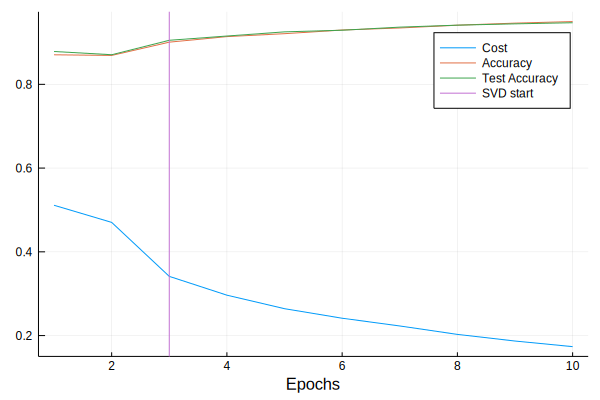

In [52]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")
vline!([2], label = "SVD start", legend = :best) # this was not placed in the correct position, sorry :-()

In [53]:
costs_onefourth = copy(costs)

10-element Array{Any,1}:
 0.51119405f0
 0.47031185f0
 0.3413464f0 
 0.2964593f0 
 0.26419395f0
 0.24141668f0
 0.22294459f0
 0.2028071f0 
 0.18695717f0
 0.17354536f0

## SVD 1/8

In [54]:
# set these values to be lesser than the above
# nothing implies that the layer is not converted to SVDense
l_values = map(x -> x ÷ 8, max_l_values)
l_values = Array{Union{Nothing, Integer}}(l_values)
l_values[end] = nothing # no SVD on the last layer, this gives much better results
l_values

3-element Array{Union{Nothing, Integer},1}:
 38       
 21       
   nothing

In [56]:
@timeit to "Full training SVD 1/8" train_epochs_svd!(model, l_values, loss, train_data, test_data, opt, opt2, 10)

Cost at epoch 1 is 0.5112786. Accuracy 0.8637558251096491. Test accuracy 0.8752108683628318
Finished pre-training
Built SVD model
SVD Model: Accuracy 0.5243275424890351. Test accuracy 0.5153225248893805
Begin tuning SVD model
Cost at epoch 1 is 0.6623464. Accuracy 0.8235428659539473. Test accuracy 0.8367706028761062
Cost at epoch 2 is 0.449996. Accuracy 0.865174410635965. Test accuracy 0.8716503042035398
Cost at epoch 3 is 0.36978203. Accuracy 0.8906284265350877. Test accuracy 0.8957757190265486
Cost at epoch 4 is 0.3272166. Accuracy 0.9038094503837719. Test accuracy 0.9084243639380531
Cost at epoch 5 is 0.29851115. Accuracy 0.9102127878289473. Test accuracy 0.9134696487831858
Cost at epoch 6 is 0.27435234. Accuracy 0.920458127741228. Test accuracy 0.9214446211283185
Cost at epoch 7 is 0.25652635. Accuracy 0.9243301123903509. Test accuracy 0.927088806692478
Cost at epoch 8 is 0.23978153. Accuracy 0.9296566611842105. Test accuracy 0.9319647054756637
Cost at epoch 9 is 0.22492541. Accura

In [57]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             779s / 25.3%            120GiB / 98.2%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training SVD          3    74.8s  37.9%   24.9s   39.2GiB  33.2%  13.1GiB
   Tuning SVD model         2    45.6s  23.1%   22.8s   27.4GiB  23.3%  13.7GiB
     [SVD] Train on...     11    26.4s  13.4%   2.40s   14.7GiB  12.5%  1.34GiB
       Calculate gr...    305    20.7s  10.5%  67.8ms   12.3GiB  10.4%  41.3MiB
       Update params      304    3.48s  1.76%  11.4ms    626MiB  0.52%  2.06MiB
       Get params          11   29.3ms  0.01%  2.67ms   1.49MiB  0.00%   139KiB
     [SVD] Calculat...     10    9.37s 

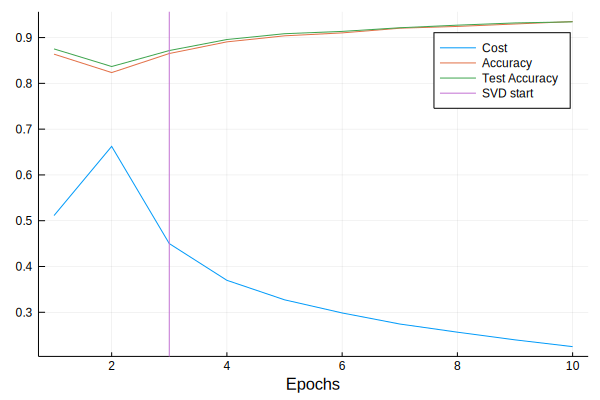

In [58]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")
vline!([2], label = "SVD start", legend = :best)  # this was not placed in the correct position, sorry :-()

In [59]:
costs_oneeight = copy(costs)

10-element Array{Any,1}:
 0.5112786f0 
 0.6623464f0 
 0.449996f0  
 0.36978203f0
 0.3272166f0 
 0.29851115f0
 0.27435234f0
 0.25652635f0
 0.23978153f0
 0.22492541f0

## Compare 1/2, 1/4, 1/8

The below graph shows how the cost is affected with the hyperparameter α (which as defined earlier indicates the fraction of singular values to keep in Truncated SVD).

With an α of 1/2, the model training is not affected at all while an α of 1/4 affects the training slightly. With α=1/8, the training is very heavily impacted.

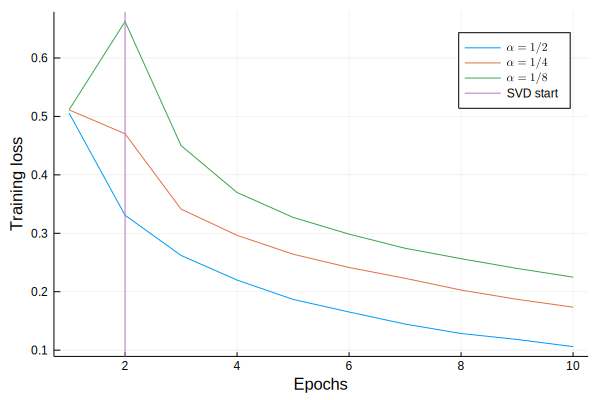

In [66]:
plot(costs_half, label = L"\alpha = 1/2")
plot!(costs_onefourth, label = L"\alpha = 1/4")
plot!(costs_oneeight, label = L"\alpha = 1/8")
xlabel!("Epochs")
ylabel!("Training loss")
vline!([2], label = "SVD start", legend = :best)

## SVD only

Train a SVD model without pre-training (phi = 0)

In [71]:
@timeit to "Full training SVD only" train_epochs_svd!(model, l_values, loss, train_data, test_data, opt, opt2, 10, 0.0)

Finished pre-training
Built SVD model
SVD Model: Accuracy 0.05670572916666667. Test accuracy 0.055815300055309734
Begin tuning SVD model
Cost at epoch 1 is 1.758858. Accuracy 0.6217405084978069. Test accuracy 0.634235861449115
Cost at epoch 2 is 0.74256074. Accuracy 0.7712505139802631. Test accuracy 0.780168003318584
Cost at epoch 3 is 0.50283086. Accuracy 0.8467936197916667. Test accuracy 0.8564306208517699
Cost at epoch 4 is 0.39120024. Accuracy 0.8833333333333333. Test accuracy 0.88800297289823
Cost at epoch 5 is 0.33469212. Accuracy 0.9009722793311403. Test accuracy 0.9021562154314159
Cost at epoch 6 is 0.30622953. Accuracy 0.9086143092105263. Test accuracy 0.9097137721238939
Cost at epoch 7 is 0.28298187. Accuracy 0.9153328878837719. Test accuracy 0.9150321487831858
Cost at epoch 8 is 0.26423827. Accuracy 0.9222759046052631. Test accuracy 0.9228636615044248
Cost at epoch 9 is 0.24935521. Accuracy 0.9264005962171052. Test accuracy 0.9259687845685841
Cost at epoch 10 is 0.23433553. 

In [72]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            1386s / 19.0%            173GiB / 98.0%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training SVD          3    74.8s  28.4%   24.9s   39.2GiB  23.1%  13.1GiB
   Tuning SVD model         2    45.6s  17.3%   22.8s   27.4GiB  16.2%  13.7GiB
     [SVD] Train on...     11    26.4s  10.0%   2.40s   14.7GiB  8.65%  1.34GiB
       Calculate gr...    305    20.7s  7.84%  67.8ms   12.3GiB  7.23%  41.3MiB
       Update params      304    3.48s  1.32%  11.4ms    626MiB  0.36%  2.06MiB
       Get params          11   29.3ms  0.01%  2.67ms   1.49MiB  0.00%   139KiB
     [SVD] Calculat...     10    9.37s 

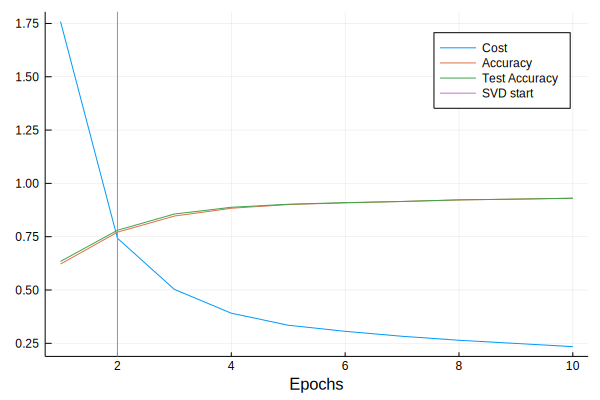

In [73]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")
vline!([2], label = "SVD start", legend = :best)

Without pre-training, the accuracy is quite a bit lower. So, pre-training definitely helps (see the paper for the reason)